# GRU

Use [TensorFlow](https://www.tensorflow.org/tutorials/text/text_generation) to train a character level GRU on the preprocessed Recipe Box dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pathlib
import os

In [3]:
CACHE_DIR = './drive/Shared drives/Capstone/tmp'
pathlib.Path(CACHE_DIR).mkdir(exist_ok=True)
dataset_path = os.path.join(CACHE_DIR, 'emoji_text_recipes.pkl')

In [4]:
if not os.path.exists(dataset_path):
    raise SystemExit("Run preprocess_rnn_char.ipynb to generate data file before continuing")
else:
    recipes = pd.read_pickle(dataset_path)

In [5]:
recipes.head()

0    🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 ...
1    🍴 Awesome Slow Cooker Pot Roast\n\n🥑\n• 2 (10....
2    🍴 Brown Sugar Meatloaf\n\n🥑\n• 1/2 cup packed ...
3    🍴 Best Chocolate Chip Cookies\n\n🥑\n• 1 cup bu...
4    🍴 Homemade Mac and Cheese Casserole\n\n🥑\n• 8 ...
dtype: object

In [11]:
# 2021-05-10 update: Add a terminating token.
recipes = recipes.apply(lambda x: x + '😋')

In [12]:
recipes[0]

'🍴 Slow Cooker Chicken and Dumplings\n\n🥑\n• 4 skinless, boneless chicken breast halves\n• 2 tablespoons butter\n• 2 (10.75 ounce) cans condensed cream of chicken soup\n• 1 onion, finely diced\n• 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces\n\n🥣\n‣ Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\n‣ Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.😋'

## Vectorize the text

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
tokenizer = Tokenizer(char_level=True, filters='', lower=False, split='')
tokenizer.fit_on_texts(recipes)

In [15]:
encoded_recipes = tokenizer.texts_to_sequences(recipes)

In [16]:
recipe_maxlen = max([len(r) for r in encoded_recipes])

In [17]:
padded_recipes = pad_sequences(encoded_recipes,
                               padding='post',
                               truncating='post',
                               maxlen=recipe_maxlen+1) # Guarantee at least 1 padding character at end

In [18]:
vocab_size = len(tokenizer.word_counts) + 1
idx2char = tokenizer.sequences_to_texts([[idx] for idx in range(vocab_size)])

In [19]:
print(vocab_size)
print(len(padded_recipes))

176
105789


# Create training examples and targets

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(padded_recipes)

In [21]:
# For each sequence, duplicate and shift it to form the input and target text
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    return input_text, target_text

dataset = dataset.map(split_input_target)

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000  # Buffer size to shuffle the dataset

# Create training batches
dataset = dataset \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .repeat() # Repeat to have enough data during training

# Build the model

In [23]:
def build_model(vocab_size, embed_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embed_dim, batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,
            recurrent_initializer='glorot_uniform'
        ),
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

In [26]:
EMBED_DIM = 256
RNN_UNITS = 1024
MODEL_NAME = "rnn_char_20210510"

In [27]:
model = build_model(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    rnn_units=RNN_UNITS,
    batch_size=BATCH_SIZE)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           45056     
_________________________________________________________________
gru_1 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_1 (Dense)              (64, None, 176)           180400    
Total params: 4,163,760
Trainable params: 4,163,760
Non-trainable params: 0
_________________________________________________________________


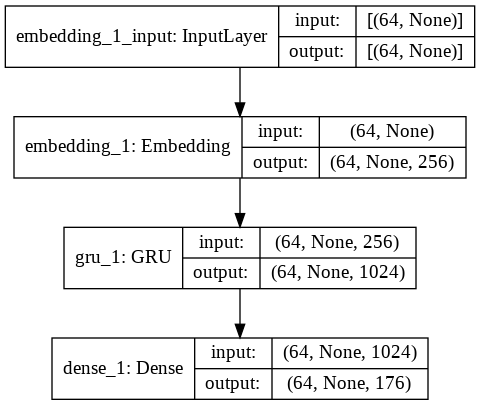

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [29]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape) # (batch_size, sequence_length, vocab_size)

(64, 2164, 176)


In [30]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    
example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2164, 176)
scalar_loss:       5.166723


In [31]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [32]:
# Create a checkpoints directory.
checkpoint_dir = os.path.join(CACHE_DIR, MODEL_NAME)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'ckpt_{epoch}'),
    save_weights_only=True
)

In [33]:
def restore_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Checkpoint not found')
        return model, 0

    print("Checkpoint found")
    print('Path:', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('Name:', latest_checkpoint_name)

    latest_epoch = latest_checkpoint_name.split('_')[-1]
    print('Epoch:', latest_epoch)

    return model, int(latest_epoch)

In [34]:
TOTAL_EPOCHS = 10
STEPS_PER_EPOCH = 1500

model, initial_epoch = restore_checkpoint(model)

Checkpoint not found


In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss
)

## Train model

In [36]:
history = model.fit(
    x=dataset,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=initial_epoch,
    verbose=True,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = os.path.join(CACHE_DIR, MODEL_NAME, f'{MODEL_NAME}.h5')
model.save(model_name, save_format='h5')

Epoch 1/10
1500/1500 [==============================] - 763s 507ms/step - loss: 0.9829
Epoch 2/10
1500/1500 [==============================] - 749s 499ms/step - loss: 0.3095
Epoch 3/10
1500/1500 [==============================] - 749s 499ms/step - loss: 0.2858
Epoch 4/10
1500/1500 [==============================] - 746s 498ms/step - loss: 0.2801
Epoch 5/10
1500/1500 [==============================] - 744s 496ms/step - loss: 0.2790
Epoch 6/10
1500/1500 [==============================] - 746s 498ms/step - loss: 0.2815
Epoch 7/10
1500/1500 [==============================] - 748s 498ms/step - loss: 0.2898
Epoch 8/10
1500/1500 [==============================] - 745s 496ms/step - loss: 0.2904
Epoch 9/10
1500/1500 [==============================] - 751s 501ms/step - loss: 0.2558
Epoch 10/10
1500/1500 [==============================] - 752s 501ms/step - loss: 0.2336


# Predictions

In [49]:
def generate_recipe(model, start_string, num_generate=1000, temperature=0.8):
    TITLE_START = "🍴 "
    # Evaluation step (generating text using the learned model)

    padded_start_string = TITLE_START + start_string

    # Converting our start string to numbers (vectorizing).
    input_eval = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated).strip('😋'))

In [38]:
# Restore latest checkpoint and change batch to 1
model = build_model(vocab_size, EMBED_DIM, RNN_UNITS, batch_size=1)
model, _ = restore_checkpoint(model)
model.build(tf.TensorShape([1, None]))

Checkpoint found
Path: ./drive/Shared drives/Capstone/tmp/rnn_char_20210510/ckpt_10
Name: ckpt_10
Epoch: 10


In [50]:
generated_text = generate_recipe(model, start_string="Chicken Tikka Masala", temperature=0.7)
print(generated_text)

Chicken Tikka Masala, refrigerated, at least 12 hours, or overnight.
‣ Preheat oven to 400 degrees F (200 degrees C).
‣ In a small bowl, mix together crumbs, salt, baking powder, baking soda, orange zest, and macaroni mix. Pour into a 2 quart casserole dish.
‣ Bake in preheated oven until cheese melts, about 30 minutes.
‣ Meanwhile, broil the peaches in a small pan over medium-high heat until they are golden brown and crumbly, evenly browned, about 5 minutes. Serve warm.


# Generate evaluation recipes

In [51]:
# Set to True for generating recipes for evaluation
GENERATE_EVAL_RECIPES = True

In [52]:
import random
from tqdm import tqdm

if GENERATE_EVAL_RECIPES:
    col_recipes = pd.read_pickle('/content/drive/Shared drives/Capstone/tmp/recipes.pkl')
    recipe_titles = col_recipes.filter(['title']).values.ravel().tolist()
    # recipe_words = set()

    # Create vocabulary of words used in recipe titles as potential inputs for generation
    # for title in recipe_titles:
    #     for word in title.split(' '):
    #         if len(word) > 0: # Don't add empty string
    #             recipe_words.add(word)

    eval_output_dir = os.path.join(CACHE_DIR, "rnn_char_20210510_title_prompt_output_recipes")
    pathlib.Path(eval_output_dir).mkdir(exist_ok=True)
    
    # Generate N recipes using random title as input to model
    N = 500
    used_titles = []

    for i in tqdm(range(N)):
        keyword = random.choice(tuple(recipe_titles))
        used_titles.append(keyword)
        output_file_name = os.path.join(eval_output_dir, f"rnn_char_recipe_{i}.txt")

        r = generate_recipe(model, start_string=keyword, temperature=0.8)
        with open(output_file_name, 'w') as f:
            f.write(r)
    
    # Save used titles for later reference
    title_list_file = os.path.join(eval_output_dir, f"titles.txt")
    with open(title_list_file, 'w') as f:
        f.writelines("%s\n" % t for t in used_titles)

100%|██████████| 500/500 [38:16<00:00,  4.59s/it]


In [ ]:
# You don't really need to run this, 
# Just housekeeping

def rename_rnn_to_rnn_char():
  path = os.path.join(CACHE_DIR, "rnn_char_title_prompt_output_recipes")
  ldseg = np.array(os.listdir(path))
  for filename in ldseg:
    if len(filename) > 4:
      prefix, suffix = filename[:4], filename[4:]
      if prefix == 'rnn_':
        new_title = prefix + 'char_' + suffix
        os.rename(os.path.join(path, filename), os.path.join(path, new_title))

if False:
  rename_rnn_to_rnn_char()

Some analysis if including an end token improved things at all

In [61]:
def recipe_stats(path):
  ldseg = np.array(os.listdir(path))
  has_ingred_token = 0
  has_instr_token = 0
  total = 0
  good_recipes = []
  for filename in ldseg:
    filepath = os.path.join(path, filename)
    with open(filepath, 'r') as fn:
      recipe = fn.read()
      flag = True
      if '🥑' in recipe:
        has_ingred_token += 1
      else:
        flag = False
      if '🥣' in recipe:
        has_instr_token += 1
      else:
        flag = False
      if flag:
        good_recipes.append(filename)
    total += 1
    if total % 10 == 0:
      print("- processed {} recipes".format(total))
  print("For {}".format(path))
  print("\t{} out of {} recipes have 🥑".format(has_ingred_token, total))
  print("\t{} out of {} recipes have 🥣".format(has_instr_token, total))
  print("{} good recipes: {}".format(len(good_recipes), good_recipes))

recipe_stats(os.path.join(CACHE_DIR, "rnn_char_title_prompt_output_recipes"))
recipe_stats(os.path.join(CACHE_DIR, "rnn_char_20210510_title_prompt_output_recipes"))

- processed 10 recipes
- processed 20 recipes
- processed 30 recipes
- processed 40 recipes
- processed 50 recipes
- processed 60 recipes
- processed 70 recipes
- processed 80 recipes
- processed 90 recipes
- processed 100 recipes
- processed 110 recipes
- processed 120 recipes
- processed 130 recipes
- processed 140 recipes
- processed 150 recipes
- processed 160 recipes
- processed 170 recipes
- processed 180 recipes
- processed 190 recipes
- processed 200 recipes
- processed 210 recipes
- processed 220 recipes
- processed 230 recipes
- processed 240 recipes
- processed 250 recipes
- processed 260 recipes
- processed 270 recipes
- processed 280 recipes
- processed 290 recipes
- processed 300 recipes
- processed 310 recipes
- processed 320 recipes
- processed 330 recipes
- processed 340 recipes
- processed 350 recipes
- processed 360 recipes
- processed 370 recipes
- processed 380 recipes
- processed 390 recipes
- processed 400 recipes
- processed 410 recipes
- processed 420 recipes
-